In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# import data and extract FRH1 region
import pandas as pd
words = pd.read_csv('oas_pair_heavy.csv', usecols=['fwr1_aa_heavy'])['fwr1_aa_heavy'].tolist()
print('Total: ', len(words))

Total:  121679


Most frequent length: 
 [(25, 119394), (24, 1473), (23, 234), (22, 195), (15, 144), (16, 47), (18, 28), (8, 27), (21, 27), (20, 22), (12, 8), (11, 8), (17, 7), (26, 7), (14, 6), (19, 6), (6, 6), (9, 5), (3, 5), (29, 4), (7, 4), (13, 3), (28, 3), (30, 3), (27, 3), (10, 3), (5, 2), (2, 2), (32, 2), (1, 1)]


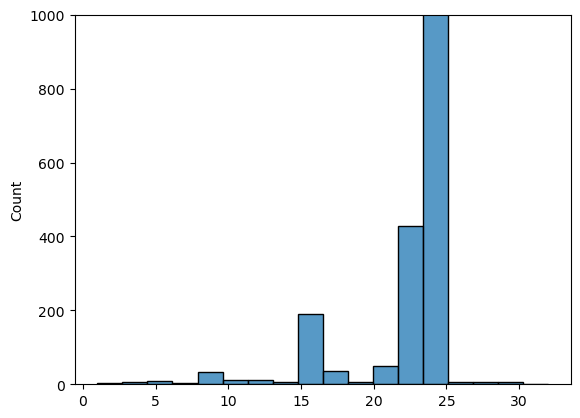

In [4]:
# visualize the length distribution of FRH1 region
from collections import Counter
length = list(map(lambda s: len(s), words))
len_cnt = Counter(length)
print("Most frequent length: \n", len_cnt.most_common(50))

sns.histplot(length)
plt.ylim((0, 1000));

In [5]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(f"Vocab size: {vocab_size}")

Vocab size: 21


In [6]:
# build the dataset:
#  given a word:
#   ...           -> <initToken>
#   ..<initToken> -> <nextToken>

block_size = 3
def build_datasets(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_datasets(words[:n1])      # 80%
Xdev, Ydev = build_datasets(words[n1:n2])  # 10%
Xte, Yte = build_datasets(words[n2:])      # 10%

torch.Size([2526147, 3]) torch.Size([2526147])
torch.Size([315632, 3]) torch.Size([315632])
torch.Size([315739, 3]) torch.Size([315739])


In [173]:
# MLP on language model
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(211111)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn(n_emb * block_size, n_hidden, generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
total_params = sum(p.nelement() for p in parameters)
print(f"Total Params: {total_params}")
for p in parameters:
    p.requires_grad = True

Total Params: 10631


tensor(-0.0013) tensor(0.9916)
tensor(-0.0094) tensor(3.1690)


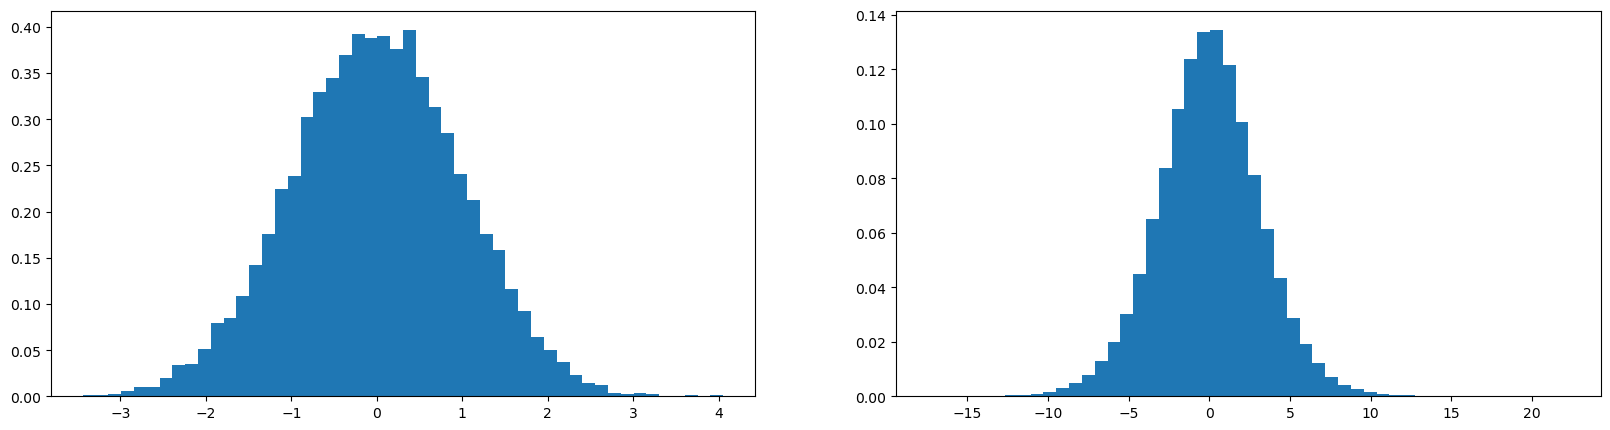

In [184]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# output spread more than input, it's won't be accepted, we should 
# make the input and output distributions keep the same range as possible
# in this situation we want to keep the input and output distributions as the 
# guassian distribution, so we need to change the w

In [174]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # shape: b, l
    
    # forward pass
    emb = C[Xb] # shape: b, l, c
    emb = emb.view(emb.shape[0], -1) # shape: b, l*c
    hpre = emb @ W1 + b1 # shape: b, h
    h = torch.tanh(hpre) # shape: b, h
    logits = h @ W2 + b2 # shape: b, n
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update params
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track progress
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.022451


In [175]:
-torch.tensor(1/21).log()

tensor(3.0445)

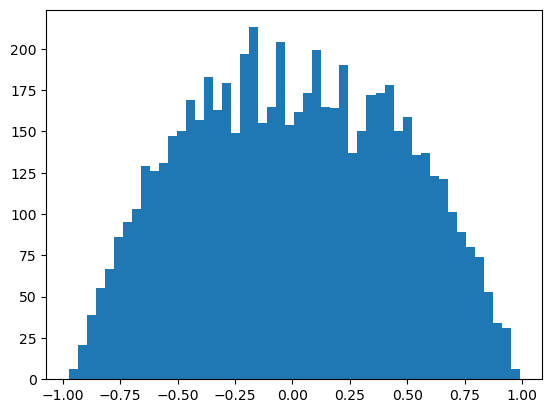

In [176]:
plt.hist(h.view(-1).tolist(), 50);

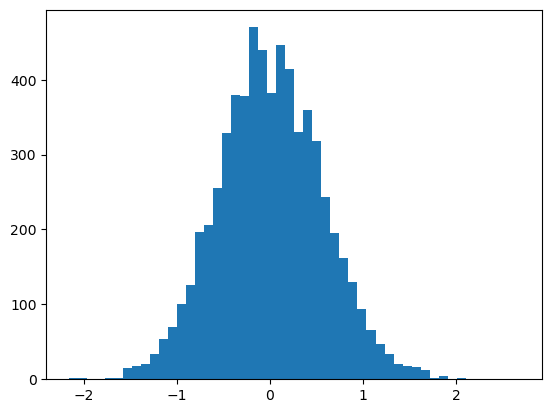

In [181]:
plt.hist(hpre.view(-1).tolist(), 50);

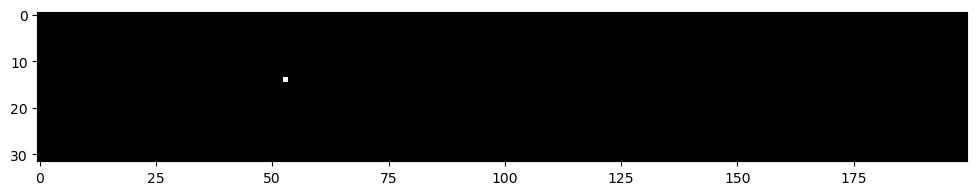

In [182]:
plt.figure(figsize=(12, 10))
# white means those are at flat tails of tanh and backpropagate will not work
# if one column (represent as one neuron) is all white then means this neuron is a dead neuron
# cannot learn anything
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

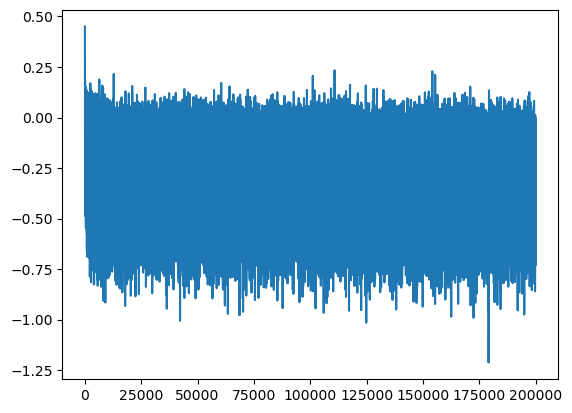

In [143]:
plt.plot(lossi)

In [142]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    emb = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.5082921385765076
val 0.5071951746940613


In [11]:
g = torch.Generator().manual_seed(211111 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] # 1, l, c
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

QVQLQESGGGLVQPKGS.
QVQLVESGPELVRPGSSVKLLQQPGRSLKLSCAAS.
VQLVESGGGLVQPGRSLKLSCAAS.
QVQLKQSGPGLVQPGGSLRLSCAAS.
QVTLKESGGGLVKPGSSVKISCKAS.
QVQLVESGGGLVKPGGSRKLSCAAS.
QLQQSGTELVKPGDSVKVSCKAS.
EVQLVESGGGLVQPSHTLSLSLTCTVS.
EVQLVQPGRSMKLSCAAS.
EVQLVQPGGSLRLSCAAS.
QVQLQQSGAEVKLLESGPGILQPSQTLSLTCTVS.
EVQLVESGPGLVKPSQTLTLTLTLTCTVT.
QVTLKESGPGLVQPGRSLRLSCTAS.
EVKLVESGGGLVQPGRSMKLSCNGS.
QVQLVQPGRSLKISCKAS.
QIQLVESGGGSLRLSCAAS.
QVQLKQSGAELVKPGESVKISCKAT.
QVQLVESGGGLVQPGRSMKLSCAAS.
EVQLKESGPGLVQPGGSLKLSCKVSCKAS.
QVQLKESGPGLVQPSQSLSLTCSVTCSFS.


In [15]:
-torch.tensor(1/vocab_size).log()

tensor(3.0445)

In [122]:
# logits = torch.tensor([-80, 0.0, 5., 0.0])
logits = torch.randn(4)*100
prob = torch.softmax(logits, dim=0)
loss = -prob[2].log()
logits, loss


(tensor([ 53.6778,  79.3425, -85.6245, -56.4950]), tensor(inf))